<a href="https://colab.research.google.com/github/gilsonauerswald/Bioinformatic_Projects/blob/main/Python_C2_12_T_Test_and_Heatmap_Results_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Welcome Back to Python Course 2!**

In the previous lesson, we covered how to perform how to make Predictive Models with Deep Learning. If you haven't completed these topics, please refer to L10 Interactive plotting with Plotly (Part 1) & L11 Interactive plotting with Plotly (Part 2) before practicing the codes for this lesson.

# **Let's Recap!**

Now that we've covered essential concepts in [L12. T-Test and Heatmap in Python](https://learn.omicslogic.com/Python/python-course-2-introduction-to-data-science-bioml/lesson/12-t-test-and-heatmap-in-python) and , let's take a moment to reinforce what we've learned so far. We'll start with a brief recap of the codes and techniques we've explored in the lesson.

In this section, we will use ResearchPy to perform statistical analysis. Read more about this package here: https://researchpy.readthedocs.io/en/latest/

Researchpy produces Pandas DataFrames that contains relevant statistical testing information that is commonly required for academic research. The information is returned as Pandas DataFrames to make for quick and easy exporting of results to any format/method that works with the traditional Pandas DataFrame.

Researchpy is essentially a wrapper that combines various established packages such as pandas, scipy.stats, numpy, and statsmodels to get all the standard required information in one method. If analyses were not available in these packages, code was developed to fill the gap.

## **1. Install Packages**

In [ ]:
!pip install researchpy --q

Now we can load all of the packages. Notice the last line where we will suppress warnings in this notebook. Warnings are different from errors because they show messages that point out code inefficiencies and not issues that will prevent code from working.

## **2. Load Packages**

In [ ]:
#import pandas
import pandas as pd
import numpy as np
import scipy as scipy
import researchpy as rp
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')


The code snippet imports the pandas, numpy, scipy, researchpy, and scipy.stats libraries for data analysis and statistics. It also suppresses warning messages using the warnings module.

This dataset has to be cleaned up before we start working with it. It also needs to be converted to numeric because we will perform statistical analysis on the data.

## **3. Load and prepare data**

In [ ]:
#load data
GeneExpression = pd.read_table('https://raw.githubusercontent.com/PineBiotech/omicslogic/master/LIHC_BRCA_data1_marked.txt')

#Set index
GeneExpression.index = GeneExpression.Id

#clean up data and convert to numeric
GeneExpression = GeneExpression.drop(['class'], axis = 0) # axis sets row or column to drop {0 or ‘index’, 1 or ‘columns’}
GeneExpression = GeneExpression.drop(['Id'], axis = 1)
GeneExpressionNum = GeneExpression.apply(pd.to_numeric)

#replace characters in gene names
GeneExpressionNum.index=GeneExpressionNum.index.str.replace('|','_')


The code snippet loads gene expression data from a URL into a DataFrame called 'GeneExpression'. It sets the index of the DataFrame to the 'Id' column, drops unnecessary rows and columns, and converts the remaining data to numeric format. Additionally, it replaces certain characters in the gene names to clean them for further analysis.

## **4. T-test**
To compare breast and liver tissue samples separately, we can separate them into their own dataframes.

Then, we can perform t-test on each comparison ("contrast") of interest

In [ ]:
#separate different datasets by tissue, type
GeneExpression_LIHC_TP = GeneExpressionNum.iloc[:, 0:3]
GeneExpression_LIHC_NT = GeneExpressionNum.iloc[:, 3:6]
GeneExpression_BRCA_TP = GeneExpressionNum.iloc[:, 6:9]
GeneExpression_BRCA_NT = GeneExpressionNum.iloc[:, 9:12]

#combine LIHC TP and NT together
LIHC = pd.concat([GeneExpression_LIHC_TP, GeneExpression_LIHC_NT], join = 'outer', axis = 1)

# perform T-test for all rows in LIHC
LIHC_results = scipy.stats.ttest_ind(GeneExpressionNum.iloc[:, 3:6], GeneExpressionNum.iloc[:, 0:3], equal_var = True, axis = 1).pvalue
LIHC['LIHC_t-test'] = LIHC_results

#combine BRCA TP and NT together
BRCA = pd.concat([GeneExpression_BRCA_TP, GeneExpression_BRCA_NT], join = 'outer', axis = 1)

# perform T-test for all rows in BRCA
BRCA_results = scipy.stats.ttest_ind(GeneExpressionNum.iloc[:, 9:12], GeneExpressionNum.iloc[:, 6:9], equal_var = True, axis = 1).pvalue
BRCA['BRCA_t-test'] = BRCA_results

# select only rows with a "good" p-value (pval < 0.05)
LIHC_sig = LIHC.loc[(LIHC['LIHC_t-test']<0.05)]
BRCA_sig = BRCA.loc[(BRCA['BRCA_t-test']<0.05)]

# determine log fold change for each row (log FC)
#(fold = mean of group 1 divided by mean of group 2; or if in log scale, mean of g1-mean of g2)
LIHC_sig['LIHC_FC'] = np.mean(LIHC_sig.iloc[:,0:3], axis=1)/np.mean(LIHC_sig.iloc[:,3:6], axis=1)
BRCA_sig['BRCA_FC'] = np.mean(BRCA_sig.iloc[:,0:3], axis=1)/np.mean(BRCA_sig.iloc[:,3:6], axis=1)
LIHC_sig['LIHC_log_FC'] = np.log(LIHC_sig['LIHC_FC'])
BRCA_sig['BRCA_log_FC'] = np.log(BRCA_sig['BRCA_FC'])

# prepare a new dataframe for genes that are statistically significant and biologically meaningful
#in gene expression difference between groups (filter for log scale greater than 1.2)
LIHC_sig = LIHC_sig.loc[(np.abs(LIHC_sig['LIHC_log_FC'])>1.2)]
BRCA_sig = BRCA_sig.loc[(np.abs(BRCA_sig['BRCA_log_FC'])>1.2)]

# combining LIHC and BRCA significant expression data
LIHC_BRCA = pd.concat([LIHC_sig.iloc[:,0:6], BRCA_sig.iloc[:,0:6]], join = 'outer', axis = 1)
# some of them end up NaN because they were not significant in one of the comparisons

The code separates gene expression datasets for different tissues and types, conducts T-tests to compare gene expression differences between groups, and calculates log fold changes (FC) for significant genes. It combines and filters the significant genes based on p-values and log fold changes, ultimately generating a DataFrame 'LIHC_BRCA' containing genes with significant and biologically meaningful expression differences between tissues 'LIHC' and 'BRCA'.

## **5. Significiant genes**

In [ ]:
#how many significant genes are there?
len(LIHC_BRCA)

2131

The code calculates and returns the number of significant genes present in the DataFrame 'LIHC_BRCA', indicating the count of genes that exhibit statistically significant and biologically meaningful expression differences between the 'LIHC' and 'BRCA' tissues.

In [ ]:
BRCA_sig.sort_values(["BRCA_log_FC"], ascending=True).head()

,TCGA-3C-AAAU-01A-11R-A41B-07_BRCA_TP,TCGA-3C-AALJ-01A-31R-A41B-07_BRCA_TP,TCGA-3C-AALK-01A-11R-A41B-07_BRCA_TP,TCGA-A7-A0CE-11A-21R-A089-07_BRCA_NT,TCGA-A7-A0CH-11A-32R-A089-07_BRCA_NT,TCGA-A7-A0D9-11A-53R-A089-07_BRCA_NT,BRCA_t-test,BRCA_FC,BRCA_log_FC
Id,,,,,,,,,
SOST_50964,0.0,0.0,0.0,3.1746,1.8806,2.0367,0.004404,0.0,-inf
RPS4Y1_6192,0.0,0.0,0.0,5.0794,8.6507,8.6558,0.003314,0.0,-inf
C10orf99_387695,0.0,0.0,0.0,2.2222,5.2656,3.0550,0.017993,0.0,-inf
SPRR2E_6704,0.0,0.0,0.0,5.0794,9.0268,13.2383,0.018004,0.0,-inf
LOC348840_348840,0.0,0.0,0.0,1.2698,1.1283,0.5092,0.014267,0.0,-inf


In [ ]:
#How many BRCA significant genes are there?
len(BRCA_sig)

1110


The code calculates and returns the number of significant genes specific to the 'BRCA' tissue, as represented by the variable 'BRCA_sig'. It indicates the count of genes that exhibit statistically significant and biologically meaningful expression differences in the 'BRCA' tissue.

In [ ]:
LIHC_sig.sort_values(["LIHC_log_FC"], ascending=True).head()

,TCGA-2V-A95S-01A-11R-A37K-07_LIHC_TP,TCGA-2Y-A9GS-01A-12R-A38B-07_LIHC_TP,TCGA-2Y-A9GU-01A-11R-A38B-07_LIHC_TP,TCGA-BC-A10Q-11A-11R-A131-07_LIHC_NT,TCGA-BC-A10T-11A-11R-A131-07_LIHC_NT,TCGA-BC-A10W-11A-11R-A131-07_LIHC_NT,LIHC_t-test,LIHC_FC,LIHC_log_FC
Id,,,,,,,,,
DDX25_29118,0.0,0.0,0.0,3.00,2.00,5.00,0.019442,0.0,-inf
MGC16703_113691,0.0,0.0,0.0,3.96,4.27,6.21,0.002395,0.0,-inf
TRH_7200,0.0,0.0,0.0,2.00,1.00,2.00,0.007490,0.0,-inf
LPO_4025,0.0,0.0,0.0,1.00,1.00,1.00,0.000000,0.0,-inf
CALN1_83698,0.0,0.0,0.0,21.00,11.00,13.00,0.007987,0.0,-inf


The code sorts the DataFrame 'LIHC_sig' in ascending order based on the 'LIHC_log_FC' column and retrieves the first few rows using the 'head()' function. This provides a view of the genes with the lowest negative log fold change values in the 'LIHC' tissue, indicating genes that are downregulated in 'LIHC'.

In [ ]:
#How many LIHC significant genes are there?
len(LIHC_sig)

1150

This code snippet calculates the number of rows (genes) in the DataFrame 'LIHC_sig'.

## **7. Visualization of Results**

To visualize the results, we can use a heatmap for significant genes. This heatmap can be made using Seaborn, which is a library for visualization in python similar to matplotlib, but with more advanced visualization capabilities.

### **HeatMap**

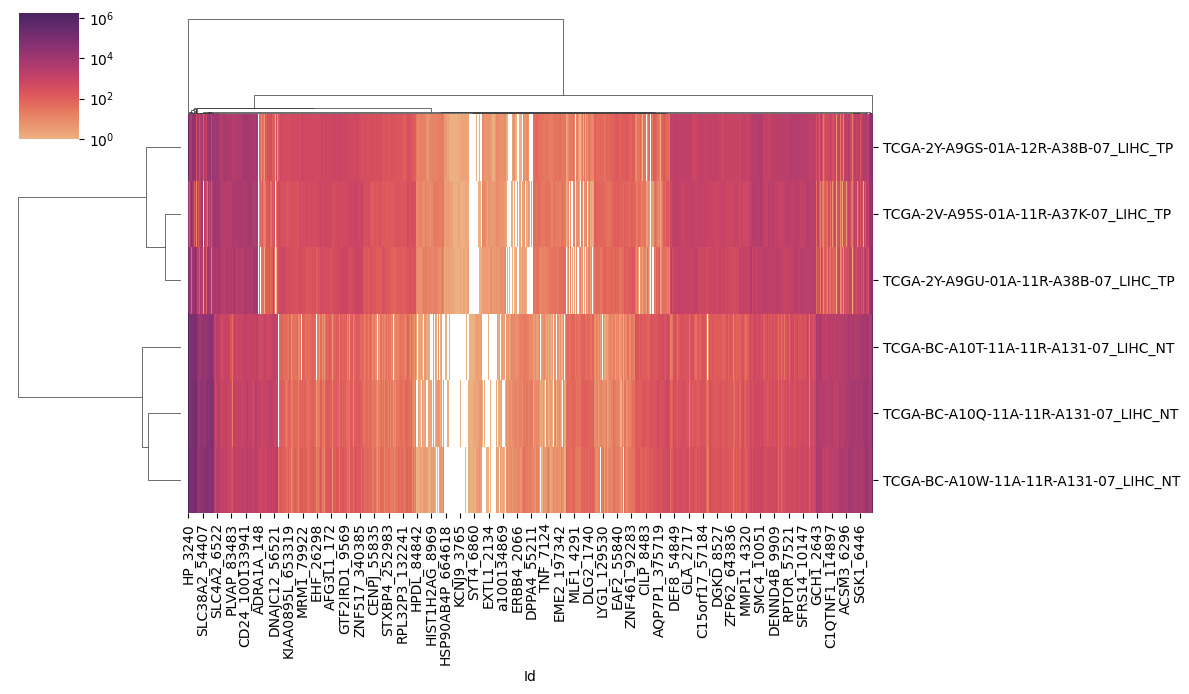

In [ ]:
import seaborn as sns
from matplotlib.colors import LogNorm

LIHC_sig_T = LIHC_sig.transpose()
LIHC_sig_T_samples = LIHC_sig_T.iloc[0:6,:]

sns.clustermap(LIHC_sig_T_samples, cmap='flare', figsize=(12, 7), norm=LogNorm())


This code generates a clustered heatmap using Seaborn, visualizing the gene expression profiles of the significant LIHC genes across samples. It applies a logarithmic color scale for improved visualization and uses the 'flare' colormap.

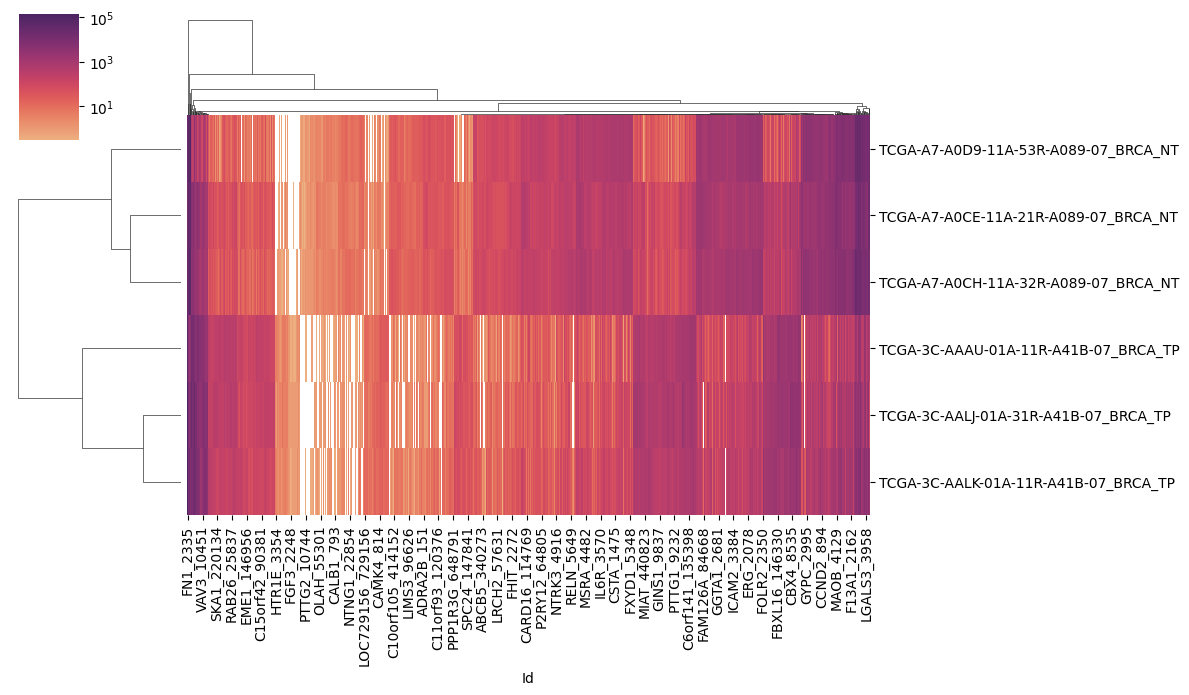

In [ ]:
BRCA_sig_T = BRCA_sig.transpose()
BRCA_sig_T_samples = BRCA_sig_T.iloc[0:6,:]

sns.clustermap(BRCA_sig_T_samples, cmap='flare', figsize=(12, 7), norm=LogNorm())

This code creates a clustered heatmap using Seaborn to display the expression patterns of significant BRCA genes across samples. The heatmap uses the 'flare' colormap and a logarithmic color scale for improved visualization.

More information about Seaborn heatmap options: https://colab.research.google.com/drive/1QcuM3gaAbKjC5djsOq-CQWe89Ay1urhE

# **For Loops**

## **1. Load and prepare data**

In [ ]:
#reload the data
GeneExpression1 = pd.read_table('https://raw.githubusercontent.com/PineBiotech/omicslogic/master/LIHC_BRCA_data1_marked.txt', header=None)

GeneExpression1.columns = GeneExpression1.iloc[0]
GeneExpression1.index = GeneExpression1.Id

GeneExpression1 = GeneExpression1.drop(index='Id')
GeneExpression1 = GeneExpression1.drop(['Id'], axis = 1)

GeneExpression1.index = GeneExpression1.index.str.replace('|','_')
GeneExpression1 = GeneExpression1.rename(index={'class':'Group'})

GeneExpression1 = GeneExpression1.transpose()
GeneExpression1 = GeneExpression1.apply(pd.to_numeric, errors="ignore")


This code reloads a dataset, sets the column names using the first row, assigns the 'Id' column as the index, and cleans up the data by removing rows with 'Id' and the 'Id' column itself. It further prepares the data for analysis by renaming rows, transposing the DataFrame, and converting the data to numeric format.

## **2. Statistical Analysis and Differential Expression in Gene Expression Data**

In [ ]:
data = []
for id in GeneExpression1.columns[1:]:
    statistic, pvalue = stats.ttest_ind(GeneExpression1[id][GeneExpression1['Group'] == 'BRCA_NT'],GeneExpression1[id][GeneExpression1['Group'] == 'BRCA_TP'])
    if pvalue < 0.0001:
      control = GeneExpression1[id][GeneExpression1['Group'] == 'BRCA_NT'].mean()
      positive = GeneExpression1[id][GeneExpression1['Group'] == 'BRCA_TP'].mean()
      if control > 0 and positive > 0:
        FC = positive/control
        important_modifier = 0.5 # limit genes to how much they're affecting fold change (1>x>0)
        if FC > (1 + important_modifier) or (FC > important_modifier and FC < 1):
          logFC = np.log2(FC)
          data.append([id, pvalue, FC, logFC, control, positive])

df = pd.DataFrame(data, columns=["ID", "PVALUE", "FC", "LOG_FC", "NT", "TP"])
df.index = df.ID
df = df.sort_values("PVALUE")

This code performs differential gene expression analysis by iterating through gene IDs, conducting a t-test for two groups, and filtering genes based on statistical significance and fold change. It calculates the mean expression for control and positive groups, computes fold change, and logs fold change values. Genes with p-values below a threshold are selected, and their information is stored in a DataFrame for further analysis and sorting based on p-values.

## **3. Summary of Statistical Analysis**

In [ ]:
print("*******************")
print("      SUMMARY      ")
print("*******************", end="\n\n")
print("Of all genes considered, %s percent were significant and biologically meaningful" % (round((len(df)/(len(GeneExpression1.columns)-1))*100, 2)))
downregulated = len(df[df['FC'] < 1])
print("There were %s upregulated genes and %s downregulated genes" % (len(df)-downregulated, downregulated), end="\n\n")
print("These were the top 10 genes with the highest signficance:")
print(df[:10][["PVALUE", "FC", "LOG_FC"]], end="\n\n")
print("These were the top 10 genes with highest postive change:")
print(df.sort_values("FC", ascending=False)[:10][["FC", "LOG_FC", "PVALUE"]], end="\n\n")
print("These were the top 10 genes with highest negative change:")
print(df[df["FC"] < 1].sort_values("FC", ascending=False)[:10][["FC", "LOG_FC", "PVALUE"]], end="\n\n")
print("These are the outliers of the dataset in terms of fold change (normalized):")
print(df[np.abs(stats.zscore(df["LOG_FC"])) > 3].sort_values("LOG_FC", ascending=False)[["LOG_FC", "FC", "PVALUE"]])

*******************
      SUMMARY      
*******************

Of all genes considered, 0.04 percent were significant and biologically meaningful
There were 6 upregulated genes and 2 downregulated genes

These were the top 10 genes with the highest signficance:
                    PVALUE         FC    LOG_FC
ID                                             
GRM2_2912         0.000007   4.575642  2.193974
LOC401010_401010  0.000014   2.288666  1.194507
PTPRO_5800        0.000015   0.567983 -0.816081
GPR68_8111        0.000018   4.530890  2.179794
DDX11_1663        0.000070   6.871353  2.780594
CCDC64_92558      0.000090  10.967757  3.455197
CEP55_55165       0.000091   6.707308  2.745734
RBM7_10179        0.000096   0.527763 -0.922038

These were the top 10 genes with highest postive change:
                         FC    LOG_FC    PVALUE
ID                                             
CCDC64_92558      10.967757  3.455197  0.000090
DDX11_1663         6.871353  2.780594  0.000070
CEP55_5516

This code snippet prints a summary of the differential gene expression analysis results, including the percentage of significant and meaningful genes, the count of upregulated and downregulated genes, top genes with the highest significance, positive change, and negative change, and outliers based on fold change. It provides an overview of the analysis outcome and key findings.


# **Practice Codes: Try it yourself**

### **Assignment 1:**
In this assignment, you will build upon your knowledge of T-Test. The provided code is incomplete, with missing syntax and portions. Your task is to complete the code to successfully import data, perform T-Test and visualize it using heatmap. To complete this, use the following txt file: https://raw.githubusercontent.com/PineBiotech/omicslogic/master/LIHC_BRCA_data1_marked.txt

In [ ]:
#import pandas
import pandas as pd
import numpy as np
import scipy as scipy
import researchpy as rp
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#load data
GeneExpression = pd.read_table('/LIHC_BRCA_data1_marked.txt')

#Set index
GeneExpression.index = GeneExpression.Id

#clean up data and convert to numeric
GeneExpression = GeneExpression.drop(['class'], axis = 0) # axis sets row or column to drop {0 or ‘index’, 1 or ‘columns’}
GeneExpression = GeneExpression.drop(['Id'], axis = 1)
GeneExpressionNum = GeneExpression.apply(pd.to_numeric)

#replace characters in gene names
GeneExpressionNum.index=GeneExpressionNum.index.str.replace('|','_')

In [ ]:
#separate different datasets by tissue, type
GeneExpression_LIHC_TP = GeneExpressionNum.iloc[:, 0:3]
GeneExpression_LIHC_NT = GeneExpressionNum.iloc[:, 3:6]
GeneExpression_BRCA_TP = GeneExpressionNum.iloc[:, 6:9]
GeneExpression_BRCA_NT = GeneExpressionNum.iloc[:, 9:12]

#combine LIHC TP and NT together
LIHC = pd.concat([GeneExpression_LIHC_TP, GeneExpression_LIHC_NT], join = 'outer', axis = 1)

# perform T-test for all rows in LIHC
LIHC_results = scipy.stats.ttest_ind(GeneExpressionNum.iloc[:, 3:6], GeneExpressionNum.iloc[:, 0:3], equal_var = True, axis = 1).pvalue
LIHC['LIHC_t-test'] = LIHC_results

#combine BRCA TP and NT together
BRCA = pd.concat([GeneExpression_BRCA_TP, GeneExpression_BRCA_NT], join = 'outer', axis = 1)

# perform T-test for all rows in BRCA
BRCA_results = scipy.stats.ttest_ind(GeneExpressionNum.iloc[:, 9:12], GeneExpressionNum.iloc[:, 6:9], equal_var = True, axis = 1).pvalue
BRCA['BRCA_t-test'] = BRCA_results

# select only rows with a "good" p-value (pval < 0.05)
LIHC_sig = LIHC.loc[(LIHC['LIHC_t-test']<)]
BRCA_sig = BRCA.loc[(BRCA['BRCA_t-test']<)]

# determine log fold change for each row (log FC)
#(fold = mean of group 1 divided by mean of group 2; or if in log scale, mean of g1-mean of g2)
LIHC_sig['LIHC_FC'] = np.mean(LIHC_sig.iloc[:,0:3], axis=1)/np.mean(LIHC_sig.iloc[:,3:6], axis=1)
BRCA_sig['BRCA_FC'] = np.mean(BRCA_sig.iloc[:,0:3], axis=1)/np.mean(BRCA_sig.iloc[:,3:6], axis=1)
LIHC_sig['LIHC_log_FC'] = np.log(LIHC_sig['LIHC_FC'])
BRCA_sig['BRCA_log_FC'] = np.log(BRCA_sig['BRCA_FC'])

# prepare a new dataframe for genes that are statistically significant and biologically meaningful
#in gene expression difference between groups (filter for log scale greater than 1.2)
LIHC_sig = LIHC_sig.loc[(np.abs(LIHC_sig['LIHC_log_FC'])>)]
BRCA_sig = BRCA_sig.loc[(np.abs(BRCA_sig['BRCA_log_FC'])>)]

# combining LIHC and BRCA significant expression data
LIHC_BRCA = pd.concat([LIHC_sig.iloc[:,0:6], BRCA_sig.iloc[:,0:6]], join = 'outer', axis = 1)
# some of them end up NaN because they were not significant in one of the comparisons

In [ ]:
#how many significant genes are there?
(LIHC_BRCA)

In [ ]:
#sort by log FC for BRCA
BRCA_sig.sort_values([""], ascending=True).head()

In [ ]:
#How many BRCA significant genes are there?
len()

In [ ]:
#sort by log FC for LIHC
LIHC_sig.sort_values([""], ascending=True).head()

In [ ]:
#How many LIHC significant genes are there?
len()

In [ ]:
#HeatMap for LIHC sample
import seaborn as sns
from matplotlib.colors import LogNorm

LIHC_sig_T = LIHC_sig.transpose()
LIHC_sig_T_samples = LIHC_sig_T.iloc[0:6,:]

sns.clustermap(LIHC, cmap='flare', figsize=(12, 7), norm=LogNorm())

In [ ]:
#HeatMap for BRCA Sample
BRCA_sig_T = BRCA_sig.transpose()
BRCA_sig_T_samples = BRCA_sig_T.iloc[0:6,:]

sns.clustermap(BRCA, cmap='flare', figsize=(12, 7), norm=LogNorm())

### **Assignment 2:**
In this assignment, you will build upon your knowledge of T-Test. The provided code is incomplete, with missing syntax and portions. Your task is to complete the code to successfully import data, perform T-Test using for loop. To complete this, use the following txt file: https://raw.githubusercontent.com/PineBiotech/omicslogic/master/LIHC_BRCA_data1_marked.txt

In [ ]:
#reload the data
GeneExpression1 = pd.read_table('/LIHC_BRCA_data1_marked.txt', header=None)

GeneExpression1.columns = GeneExpression1.iloc[0]
GeneExpression1.index = GeneExpression1.Id

GeneExpression1 = GeneExpression1.drop(index='Id')
GeneExpression1 = GeneExpression1.drop(['Id'], axis = 1)

GeneExpression1.index = GeneExpression1.index.str.replace('|','_')
GeneExpression1 = GeneExpression1.rename(index={'class':'Group'})

GeneExpression1 = GeneExpression1.transpose()
GeneExpression1 = GeneExpression1.apply(pd.to_numeric, errors="ignore")

In [ ]:
data = [
for id in GeneExpression1.columns[1:]:
    statistic, pvalue = stats.ttest_ind(GeneExpression1[id][GeneExpression1['Group'] == 'BRCA_NT'],GeneExpression1[id][GeneExpression1['Group'] == 'BRCA_TP'])
    if pvalue < 0.0001:
      control = GeneExpression1[id][GeneExpression1['Group'] == 'BRCA_NT'].mean()
      positive = GeneExpression1[id][GeneExpression1['Group'] == 'BRCA_TP'].mean()
      if control > 0 and positive > 0:
        FC = positive/control
        important_modifier = 0.5 # limit genes to how much they're affecting fold change (1>x>0)
        if FC > (1 + important_modifier) or (FC > important_modifier and FC < 1):
          logFC = np.log2(FC)
          data.append([id, pvalue, FC, logFC, control, positive])

df = pd.DataFrame(, columns=["ID", "PVALUE", "FC", "LOG_FC", "NT", "TP"])
df.index = df.ID
df = df.sort_values("PVALUE")

In [ ]:
print("*******************")
print("      SUMMARY      ")
print("*******************", end="\n\n")
print("Of all genes considered, %s percent were significant and biologically meaningful" % (round((len(df)/(len(GeneExpression1.columns)-1))*100, 2)))
downregulated = len(df[df['FC'] < 1])
print("There were %s upregulated genes and %s downregulated genes" % (len(df)-downregulated, downregulated), end="\n\n")
print("These were the top 10 genes with the highest signficance:")
print(df[:10][["PVALUE", "FC", "LOG_FC"]], end="\n\n")
print("These were the top 10 genes with highest postive change:")
print(df.sort_values("FC", ascending=False)[:10][["FC", "LOG_FC", "PVALUE"]], end="\n\n")
print("These were the top 10 genes with highest negative change:")
print(df[df["FC"] < 1].sort_values("FC", ascending=False)[:10][["FC", "LOG_FC", "PVALUE"]], end="\n\n")
print("These are the outliers of the dataset in terms of fold change (normalized):")
print(df[np.abs(stats.zscore(df["LOG_FC"])) > 3].sort_values("LOG_FC", ascending=False)[["LOG_FC", "FC", "PVALUE"]])